In [7]:
% matplotlib inline
import pandas as pd
from pymongo import MongoClient
import matplotlib.ticker as plticker
db = MongoClient().imdbws
df = pd.DataFrame(list(db.titles.find({'is_subject': True})))

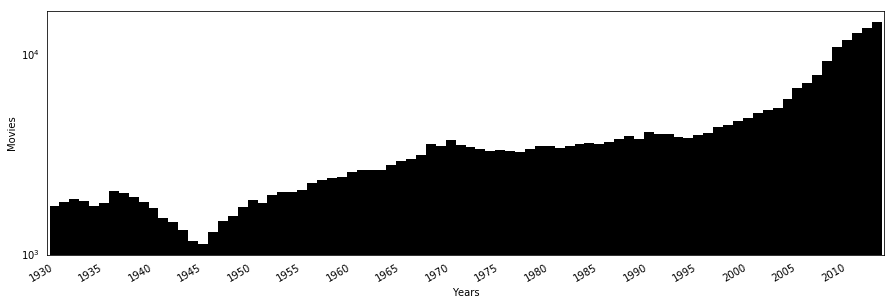

In [75]:
hist = df.groupby(df["startYear"])._id.count()
ax = hist.plot(kind="bar", figsize=(15,5), color='0.0', logy=True, width=1.0)
locator = ax.xaxis.get_major_locator()
locator.locs = locator.locs[::5]
formatter = ax.xaxis.get_major_formatter()
formatter.seq = formatter.seq[::5]
ax.get_figure().autofmt_xdate()
ax.set_ylabel('Movies')
ax.set_xlabel('Years')
ax.tick_params(which='both', bottom='off', top='off', left='off', right='off')